# Visualize Results of Trained Models

This demo loads trained models and runs a number of visualizations including comparing the output of two models, looking at individual convolution filter, and comparing input channel ablation.

In [3]:
from deeplab3.dataloaders import make_dataset
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from deeplab3.utils import model_utils
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math, os

from types import SimpleNamespace

### Configuration 

Primary Model

In [4]:
model_name = 'RGBD'
cfg_filepath = '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml'
cfg_list = []

cfg = model_utils.match_cfg_versions(cfg_filepath)
cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                     'TEST.MAX_ITER', 1000,
                     'MODEL.PRETRAINED', "",
                     'SYSTEM.GPU_IDS', [0]])
cfg.merge_from_list(cfg_list)

Non-existent key: DATASET.CITYSCAPES.TEST_SET


Comparison Model

In [5]:
model_name2 = 'RGB'
cfg_filepath2 = '../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml'
cfg_list2 = []

cfg2 = model_utils.match_cfg_versions(cfg_filepath2)
cfg2.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath2),
                     'TEST.MAX_ITER', 1000,
                     'MODEL.PRETRAINED', "",
                     'SYSTEM.GPU_IDS', [0]])
cfg2.merge_from_list(cfg_list)

Dataset

In [6]:
# Dataset directory root
root = '../datasets/cityscapes/'

cfg.merge_from_list(['DATASET.ROOT', root])
dataset = make_dataset(cfg, 'val')

cfg2.merge_from_list(['DATASET.ROOT', root])
dataset2 = make_dataset(cfg2, 'val')

Using RGB-D input
Found 500 val images
Using RGB input
Found 500 val images


Load a saved model and visualize results
-----

The trained model takes an image input and produces a segmentation mask. In this section, we look at the different segmentation masks produced by the primary and comparison models.

In [7]:
import torch
import os
from deeplab3.dataloaders import make_data_loader
from deeplab3.modeling.sync_batchnorm.replicate import patch_replication_callback
from deeplab3.modeling.deeplab import *

In [8]:
## Load saved model
def load_model(cfg):
    """Loads a saved model from a checkpoint"""
    model = DeepLab(cfg)

    if cfg.SYSTEM.CUDA:
        model = torch.nn.DataParallel(model, device_ids=cfg.SYSTEM.GPU_IDS)
        patch_replication_callback(model)
        model = model.cuda()

    model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
    
    if not os.path.isfile(model_filepath):
        raise RuntimeError("=> no checkpoint found at '{}'" .format(model_filepath))
    checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
    cfg.TRAIN.START_EPOCH = checkpoint['epoch']
    if cfg.SYSTEM.CUDA:
        model.module.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint['state_dict'])
    best_pred = checkpoint['best_pred']
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(cfg.CHECKPOINT.DIRECTORY, checkpoint['epoch']))
    return model

In [9]:
# Load the primary model
model = load_model(cfg)
model.eval()

Training backbone from scratch
=> loaded checkpoint '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16' (epoch 1)


DataParallel(
  (module): DeepLab(
    (backbone): AlignedXception(
      (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (rep): Sequential(
          (0): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (pointwise): Conv2d(64, 128, 

In [10]:
# Load the comparison model
model2 = load_model(cfg2)
model2.eval()

Loading pretrained Xception model: http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth
=> loaded checkpoint '../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22' (epoch 9)


DataParallel(
  (module): DeepLab(
    (backbone): AlignedXception(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (rep): Sequential(
          (0): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (pointwise): Conv2d(64, 128, 

In [11]:
def display_results(cfg, loader, image, target, image2=None):
    if cfg.SYSTEM.CUDA:
        image, target = image.cuda(), target.cuda()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    
    image = image.cpu()
    target = target.cpu().numpy()
    
    pred = output.data.cpu().squeeze().numpy()
    pred = np.argmax(pred, axis=0)
    
    if image2 is not None:
        if cfg.SYSTEM.CUDA:
            image2 = image2.cuda()
        with torch.no_grad():
            output2 = model2(image2.unsqueeze(0))
        pred2 = output2.data.cpu().squeeze().numpy()
        pred2 = np.argmax(pred2, axis=0)
        
    img_tmp = loader.invert_normalization(image)

    segmap = decode_segmap(target, dataset=cfg.DATASET.NAME)
    segmap_pred = decode_segmap(pred, dataset=cfg.DATASET.NAME)

    plt.figure(figsize=(16, 4))
    plt.subplot(151)
    plt.imshow(img_tmp[:,:,:3])
    plt.title('RGB')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(img_tmp[:,:,3])
    plt.title('Depth')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(segmap) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title('GT')
    plt.axis('off')

    plt.subplot(154)
    plt.imshow(segmap_pred) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title(model_name + ' Prediction')
    plt.axis('off')

    if image2 is not None:
        segmap2 = decode_segmap(pred2, dataset=cfg.DATASET.NAME)
        plt.subplot(155)
        plt.imshow(segmap2) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title(model_name2 + ' Prediction')
        plt.axis('off')


['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


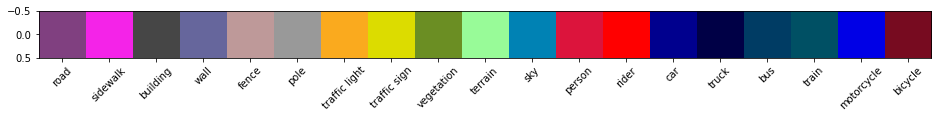

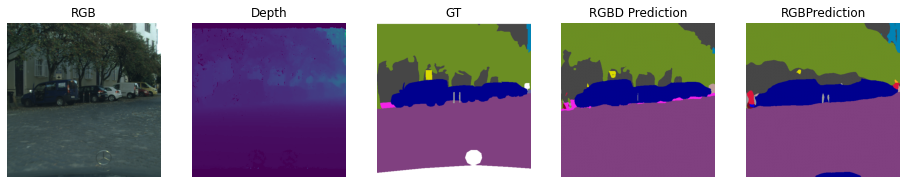

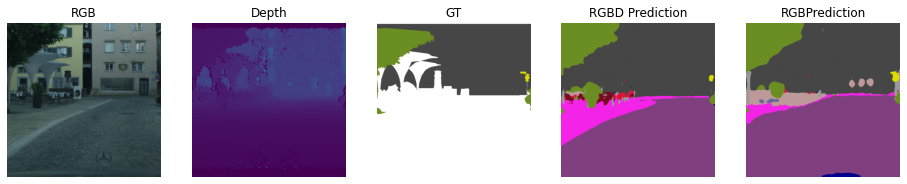

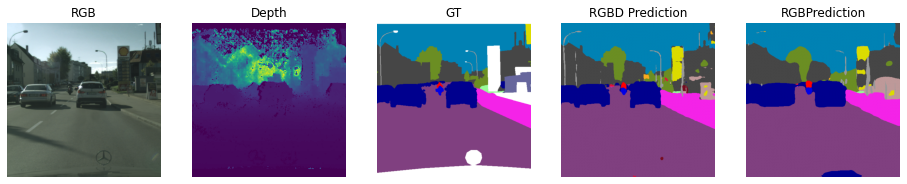

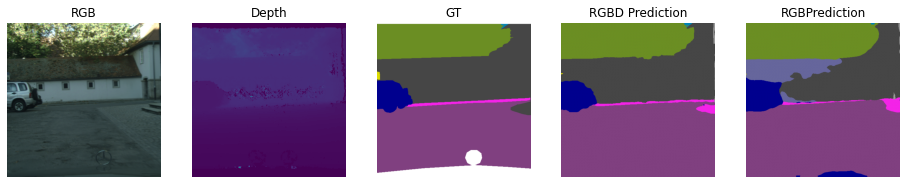

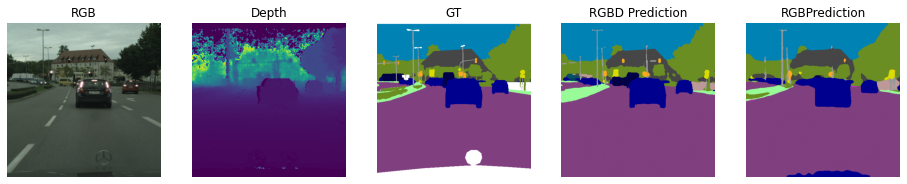

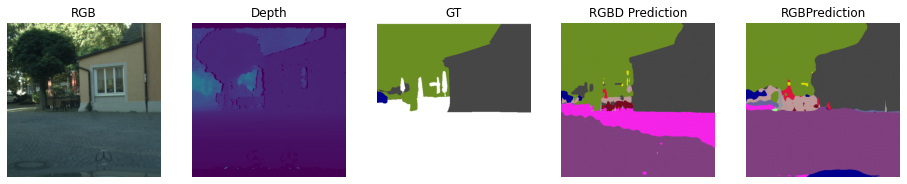

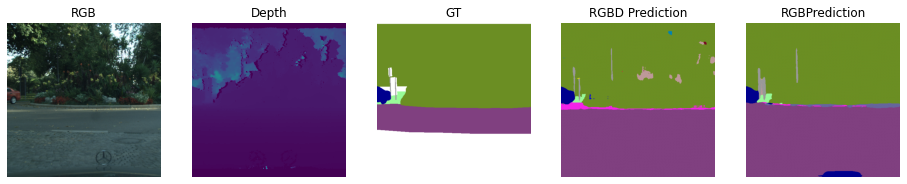

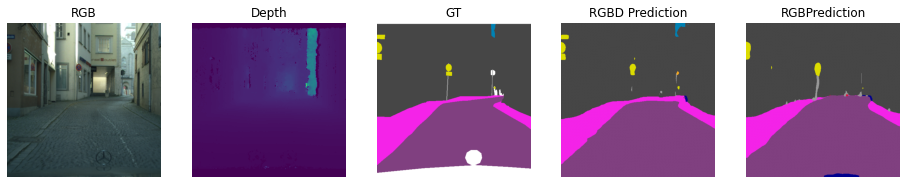

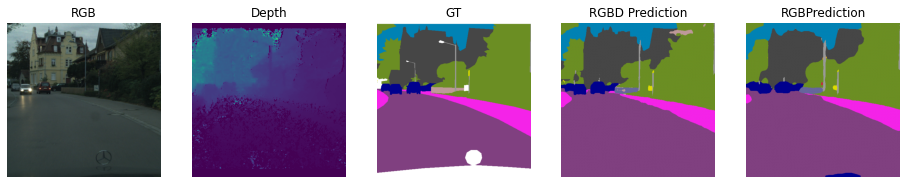

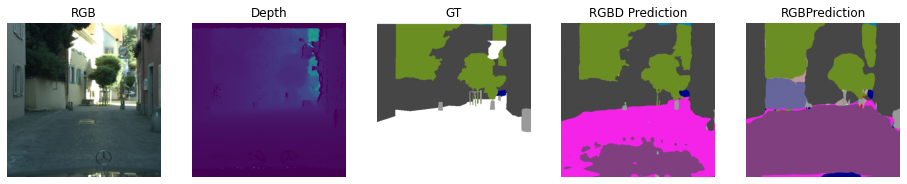

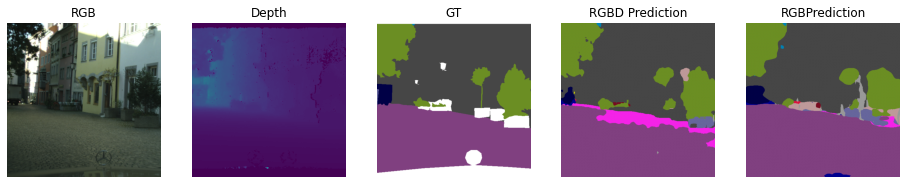

In [12]:
from deeplab3.dataloaders import get_label_colors

#Class colors for reference
labels = [x.replace('_', ' ') for x in dataset.loader.class_names]

plt.figure(figsize=(16, 1))
plt.imshow(np.expand_dims(get_label_colors(cfg), 0))
plt.xticks(range(len(labels)), labels, rotation=45)
print(labels)

# Test images 

for ii, sample in enumerate(dataset):
    image, target = sample['image'], sample['label']
    image2 = dataset2[ii]['image']
    display_results(cfg, dataset.loader, image, target, image2)
    
    if ii==10:
        break

plt.show(block=True)


## Network Investigation

The following sections dive deeper into the primary model.

### Convolutional Filter Visualization

Code modified from https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [17]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols + 1

def plot_filters_single_channel(t, fig):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 4
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

def plot_filters_multi_channel(t, fig, num_cols=2, current_col=0):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #rows = num of kernels
    num_rows = num_kernels

    #looping through all the kernels
    for i in range(t.shape[0]):
#         if i == 0:
#             print(t[i])
        ind = sub2ind((num_rows, num_cols), i, current_col)
        ax1 = fig.add_subplot(num_rows,num_cols,ind)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #TODO Is this normalization the correct way of visualizing? 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        if len(t.shape) == 4:
            npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])   
    
def plot_weights(layer):
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data.cpu()
    
    #set the figure size
    num_cols = 2
    num_rows = weight_tensor.shape[0]
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    plot_filters_multi_channel(weight_tensor[:,:3, :, :], fig)
    plot_filters_multi_channel(weight_tensor[:, 3, :, :], fig, current_col=1)
        
  else:
    print("Can only visualize layers which are convolutional")                          
  
  plt.tight_layout()
  plt.show()

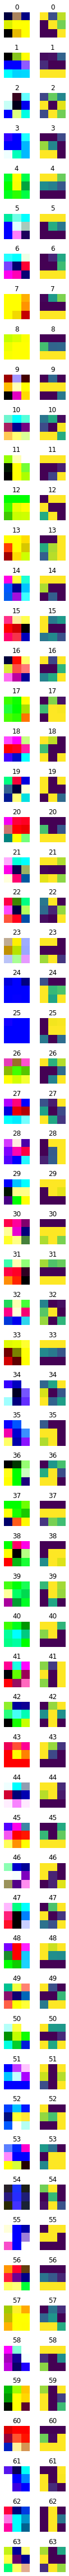

In [22]:
#visualize weights for model - first conv layer
plot_weights(model.module.backbone.conv1)


### Depth Ablation Study


torch.Size([4, 513, 513])


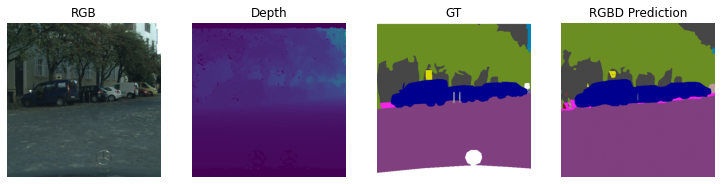

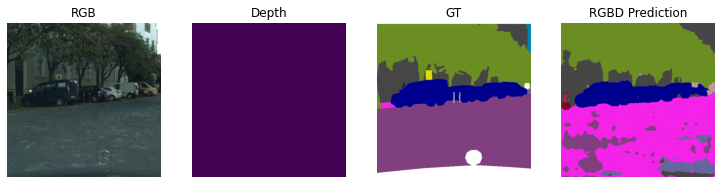

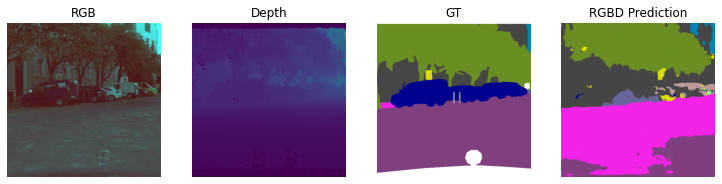

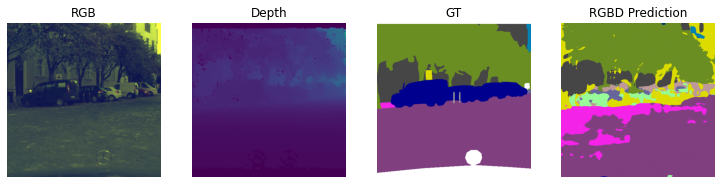

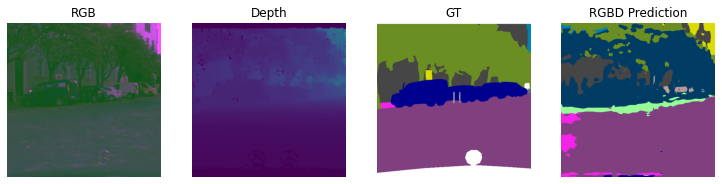

In [13]:
for ii, sample in enumerate(dataset):
    image, target = sample['image'], sample['label']
    print(image.shape)
    
    # Full RGBD
    display_results(cfg, dataset.loader, image.clone(), target)
    
    # No depth
    rgb_image = image.clone()
    rgb_image[3, :, :] = 0
    display_results(cfg, dataset.loader, rgb_image, target)
    
    # No red channel 
    gbd_image = image.clone()
    gbd_image[0, :, :] = 0
    display_results(cfg, dataset.loader, gbd_image, target)
    
     # No blue channel 
    rgd_image = image.clone()
    rgd_image[2, :, :] = 0
    display_results(cfg, dataset.loader, rgd_image, target)
    
     # No green channel 
    rbd_image = image.clone()
    rbd_image[1, :, :] = 0
    display_results(cfg, dataset.loader, rbd_image, target)

    break

plt.show(block=True)

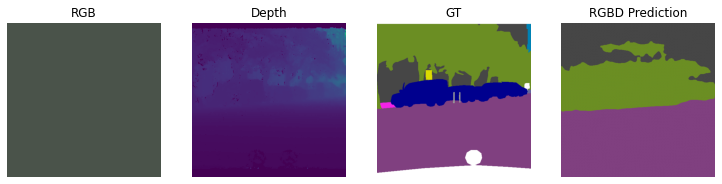

In [14]:
# Depth Only
for ii, sample in enumerate(dataset):
    image, target = sample['image'], sample['label']
    image[0:3, :, :] = 0
    display_results(cfg, dataset.loader, image, target)

    break

plt.show(block=True)

### Loss


In [15]:
from deeplab3.utils.loss import SegmentationLosses
from deeplab3.evaluators.evaluator import Evaluator
from tqdm import tqdm.notebook.tqdm

def evaluation(cfg, model_name, model, dataloader, loss_type='ce', class_weights=None):
    criterion = SegmentationLosses(weight=class_weights, cuda=model.cuda).build_loss(mode=loss_type)
    evaluator = Evaluator(dataloader.dataset.loader.NUM_CLASSES)
    
    model.eval()
    evaluator.reset()
    tbar = tqdm.notebook.tqdm(dataloader, desc='\r')
    test_loss = 0.0
    for i, sample in enumerate(tbar):
        image, target = sample['image'], sample['label']
        if model.cuda:
            image, target = image.cuda(), target.cuda()
        with torch.no_grad():
            output = model(image)
        loss = criterion(output, target)
        test_loss += loss.item()
        tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        # Add batch sample into evaluator
        evaluator.add_batch(target, pred)

    # Fast test during the training
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    
    print('{}:'.format(model_name))
    print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    print('Loss: %.3f' % test_loss)

In [16]:
dataloader = make_data_loader(cfg)
evaluation(cfg, model_name, model, dataloader[0])

Using RGB-D input
Found 19997 train_extra images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 1525 test images


<ipython-input-15-b6a4e9bd4650>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tbar = tqdm_notebook(dataloader, desc='\r')


KeyboardInterrupt: 

### Confusion Matrix